# Demo 4: SAM2 & Depth Anything2 Inference examples

In [1]:
import faulthandler

import logging
import os
from logging import StreamHandler
import numpy as np
from typing import Dict, List, Optional
import torch
import sys
import subprocess
from tqdm import tqdm

from atek.util.file_io_utils import load_yaml_and_extract_tar_list

import os
from typing import List

import cv2

import matplotlib.pyplot as plt
import numpy as np

import webdataset as wds
from atek.data_loaders.atek_wds_dataloader import (
     load_atek_wds_dataset,
     simple_list_collation_fn
)
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from webdataset.filters import pipelinefilter

%matplotlib inline

# Data path setups
data_dir = "/home/louy/Calibration_data_link/Atek/2024_08_05_DryRun"
streamable_atek_yaml_file = os.path.join(data_dir, "streamable_yamls", "streamable_validation_tars.yaml")

# Pre-traineed model paths
sam2_model_checkpoint = "/home/louy/Calibration_data_link/Atek/pre_trained_models/sam2_hiera_large.pt"
sam2_model_cfg = "sam2_hiera_l.yaml"
depth_anything_model_path = "/home/louy/Calibration_data_link/Atek/pre_trained_models/depth_anything_v2_vitl.pth"

#### Visualization functiosn from original SAM2 repo
def show_mask(mask, ax, random_color=False, borders=True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2

        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [
            cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours
        ]
        mask_image = cv2.drawContours(
            mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2
        )
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def show_masks(
    image,
    masks,
    scores,
    point_coords=None,
    box_coords=None,
    input_labels=None,
    borders=True,
):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis("off")
        plt.show()



## SAM2 inference with preprocessed ATEK data from Data Store

### SAM2 Model Adaptor class to convert from ATEK data to SAM2 format

In [2]:
class Sam2ModelAdaptor:
    """
    A simple model adaptor class to convert ATEK WDS data to Sam2 format.
    Currently used for inference examples.
    """

    def __init__(
        self,
        num_boxes: int = 5,  # num of 2d bboxes to keep as prompts
    ):
        self.num_boxes = num_boxes

    @staticmethod
    def get_dict_key_mapping_all():
        dict_key_mapping = {
            "mfcd#camera-rgb+images": "image",
            # Needs GT data to get 2D bboxes, can be used as prompts.
            "gt_data": "gt_data",
        }
        return dict_key_mapping

    def atek_to_sam2(self, data):
        """
        Core data conversion function
        """
        for atek_wds_sample in data:
            sample = {}

            # Add images
            # from [1, C, H, W] to [H, W, C]
            image_torch = atek_wds_sample["image"].clone().detach()
            image_np = image_torch.squeeze(0).permute(1, 2, 0).numpy()
            sample["image"] = image_np

            # Select
            obb2_gt = atek_wds_sample["gt_data"]["obb2_gt"]["camera-rgb"]
            num_box = min(self.num_boxes, len(obb2_gt["category_names"]))
            bbox_ranges = obb2_gt["box_ranges"][
                0:num_box, [0, 2, 1, 3]
            ]  # First K bboxes, [K, 4], xxyy -> xyxy
            sample["boxes"] = bbox_ranges.numpy()  # xxyy -> xyxy

            yield sample


def create_atek_dataloader_as_sam2(
    urls: List[str],
    batch_size: Optional[int] = None,
    repeat_flag: bool = False,
    shuffle_flag: bool = False,
    num_workers: int = 0,
    num_prompt_boxes: int = 5,
) -> torch.utils.data.DataLoader:

    adaptor = Sam2ModelAdaptor(num_boxes=num_prompt_boxes)
    wds_dataset = load_atek_wds_dataset(
        urls,
        batch_size=batch_size,
        dict_key_mapping=Sam2ModelAdaptor.get_dict_key_mapping_all(),
        data_transform_fn=pipelinefilter(adaptor.atek_to_sam2)(),
        collation_fn=simple_list_collation_fn,
        repeat_flag=repeat_flag,
        shuffle_flag=shuffle_flag,
    )

    return torch.utils.data.DataLoader(
        wds_dataset, batch_size=None, num_workers=num_workers, pin_memory=True
    )

### Load SAM2 model, and run inference on streamed ATEK WDS data

/home/louy/miniconda3/envs/atek-examples/lib/python3.10/site-packages/webdataset/compat.py:136: UserWarning: WebDataset(shardshuffle=...) is None; set explicitly to False or a number
  warnings.warn("WebDataset(shardshuffle=...) is None; set explicitly to False or a number")


 SAM2 resulting mask shapes are (10, 1, 1408, 1408)


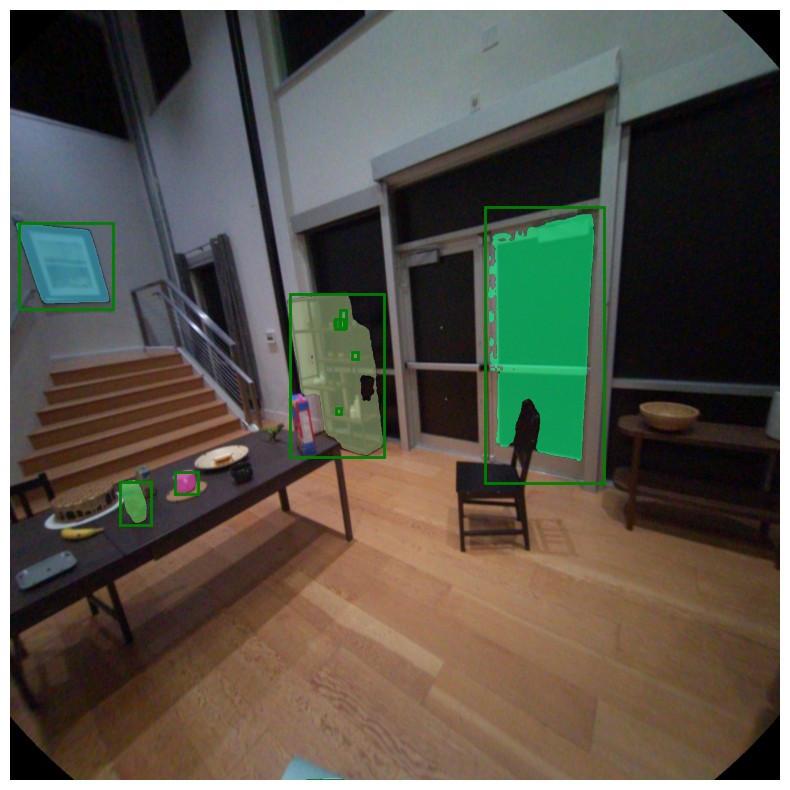

Press Enter to continue... 


<Figure size 640x480 with 0 Axes>

 SAM2 resulting mask shapes are (10, 1, 1408, 1408)


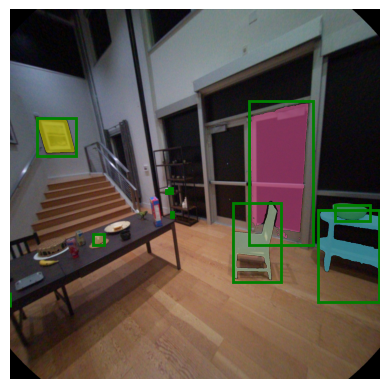

Press Enter to continue... 


<Figure size 640x480 with 0 Axes>

 SAM2 resulting mask shapes are (10, 1, 1408, 1408)


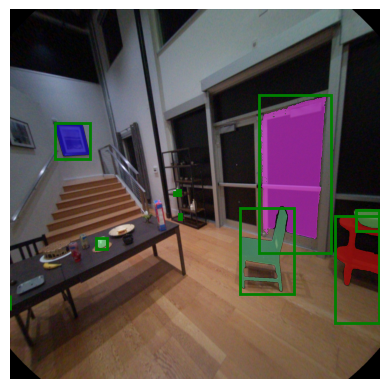

Exception ignored in: <function Pipe.__del__ at 0x7f8fca977c70>
Traceback (most recent call last):
  File "/home/louy/miniconda3/envs/atek-examples/lib/python3.10/site-packages/webdataset/gopen.py", line 121, in __del__
    self.close()
  File "/home/louy/miniconda3/envs/atek-examples/lib/python3.10/site-packages/webdataset/gopen.py", line 109, in close
    self.wait_for_child()
  File "/home/louy/miniconda3/envs/atek-examples/lib/python3.10/site-packages/webdataset/gopen.py", line 83, in wait_for_child
    raise IOError(f"{self.args}: exit {self.status} (read) {info}")
OSError: (("curl --connect-timeout 30 --retry 30 --retry-delay 2 -f -s -L 'https://scontent.xx.fbcdn.net/m1/v/t6/An9V_XtVZSSXXm8pI6a9RSmY1hbVzZ2zi7wj9IW16Vm_fc9vIiXbAsn90dLWFnfju8tDEPq9UU1hP2u0GgU-0VYz1AGtUEYwpkOkfLIIYh8LFrSvnKMwv5Hk2nsWRNozHPbzThkMHcpGtvj3mGAqZs46DQ4047A51ldcXPxqOcDXrqKNFbI.tar/AriaDigitalTwin_2_0_ATEK_cubercnn_Apartment_release_clean_seq142_M1292_shards-0000.tar?ccb=10-5&oh=00_AYDX55OtGscQBuDfuJb3IDQA

KeyboardInterrupt: Interrupted by user

In [3]:
from IPython.display import display
# create SAM2 predictor
predictor = SAM2ImagePredictor(build_sam2(sam2_model_cfg, sam2_model_checkpoint))

# load ATEK dataset
tar_list = load_yaml_and_extract_tar_list(streamable_atek_yaml_file)
sam2_dataloader = create_atek_dataloader_as_sam2(tar_list, num_prompt_boxes = 10)

# Perform model inference
plt.figure(figsize=(10, 10))
with torch.inference_mode(), torch.autocast("cuda", dtype=torch.bfloat16):
    for sam_dict in sam2_dataloader:
        # perform inference
        image = sam_dict["image"].numpy()  # [H, W, 3]
        predictor.set_image(image)

        masks, scores, _ = predictor.predict(
            point_coords=None,
            point_labels=None,
            box=sam_dict["boxes"],
            multimask_output=False,
        )

        # Visualize results (taken from SAM2's own visualization code)
        print(f" SAM2 resulting mask shapes are {masks.shape}")
        plt.imshow(image)
        for mask in masks:
            show_mask(
                mask.squeeze(0), plt.gca(), random_color=True, borders=False
            )
        for box in sam_dict["boxes"]:
            show_box(box, plt.gca())
        plt.axis("off")
        plt.show()
        input("Press Enter to continue...")
        display(plt.gcf())  # Display the current figure
        plt.clf()  # Clear the figure after displaying

In [ ]:
### 